# Сеть фитнес-центров «Культурист-датасаентист»

**Цель исследования:**
- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты пользователей: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:

 - выделить целевые группы клиентов;
 - предложить меры по снижению оттока;
 - определить другие особенности взаимодействия с клиентами.

**Ход исследования:** Данные берем из файла:
- gym_churn.csv

В котором содержатся данные на месяц до оттока и факт оттока на определённый месяц. На основании полученных данных проведем исследование.

**Этапы исследования:**

- Загрузка данных;
- Исследовательский анализ данных (EDA);
- Построение модели прогнозирования оттока пользователей;
- Кластеризация пользователей;
- Выводы и базовые рекомендации.

**Описание данных:**

Набор данных включает следующие поля:
1) Данные клиента за предыдущий до проверки факта оттока месяц:
- 'gender' — пол;
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- 'Phone' — наличие контактного телефона;
- 'Age' — возраст;
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).

2) Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
- 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
- 'Group_visits' — факт посещения групповых занятий;
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.

3) 'Churn' — факт оттока в текущем месяце.

In [1]:
pip install joypy

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import joypy

#### Шаг 1. Загрузка данных

In [3]:
# Загружаем файл
pth1 = '/content/gym_churn.csv'

if os.path.exists(pth1):
    gym_churn = pd.read_csv(pth1)
else:
    print('Что-то не так с файлом. Проверь файл с данными.')

In [4]:
# Выведем таблицу
gym_churn.head(10)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
5,1,1,0,0,1,1,1,34,450.743960,1.0,3,2.623477,2.637007,0
6,1,1,1,1,0,6,1,32,94.266389,6.0,2,1.138941,1.277242,0
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387,1
8,1,1,1,1,1,1,1,23,45.409909,1.0,1,1.106239,1.059333,0
9,0,1,0,0,1,1,0,31,65.310836,1.0,11,1.810852,1.951368,0


#### Шаг 2. Исследовательский анализ данных (EDA)

In [5]:
# Выведем размер таблицы
gym_churn.shape

(4000, 14)

In [6]:
# Затем посмотрим на общую информацию
gym_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Из полученных данных понимаем что пустых строк в таблице нет.

In [7]:
# Посмотрим на средние значения и стандартные отклонения
gym_churn.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Из полученных данным не выявлено каких-то аномальных значений. Средний возраст посетителей 29 лет, практически не отличается от медианы, следовательно выбросов в данных по возрасту нет.

In [8]:
# Средние значения по группам — тех, кто ушел в отток и тех, кто остался
gym_churn.groupby(['Churn']).mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


На основании полученных данных можно сделать следующие выводы:

В группе оттока находится меньше пользователей кто проживает или работает в районе фитнес-центра. Так же меньше сотрудников компаний партнеров и тех кто пришел по акции "Приведи друга". При этом больше пользователей у кого длительность текущего абонемента от 1 до 2 месяцев и время до заверения контракта в этом же интервале. Меньше пользователей кто посещал групповые занятия. В группе оттока меньше суммарная выручка от других услуг фитнес-центра. Так же в группе оттока в несколько раз меньше время с момента первого визита.

In [9]:
# Проверим количество строк в группах по оттоку
gym_churn.groupby(['Churn'])['gender'].count()

Churn
0    2939
1    1061
Name: gender, dtype: int64

In [10]:
# Разделим таблицу на две по признаку оттока
gym_churn_stayed = gym_churn.loc[gym_churn['Churn'] == 0]
gym_churn_gone = gym_churn.loc[gym_churn['Churn'] == 1]
print(gym_churn_stayed.groupby(['Churn'])['gender'].count())
print(gym_churn_gone.groupby(['Churn'])['gender'].count())

Churn
0    2939
Name: gender, dtype: int64
Churn
1    1061
Name: gender, dtype: int64


Видим что разделили таблицу верно.

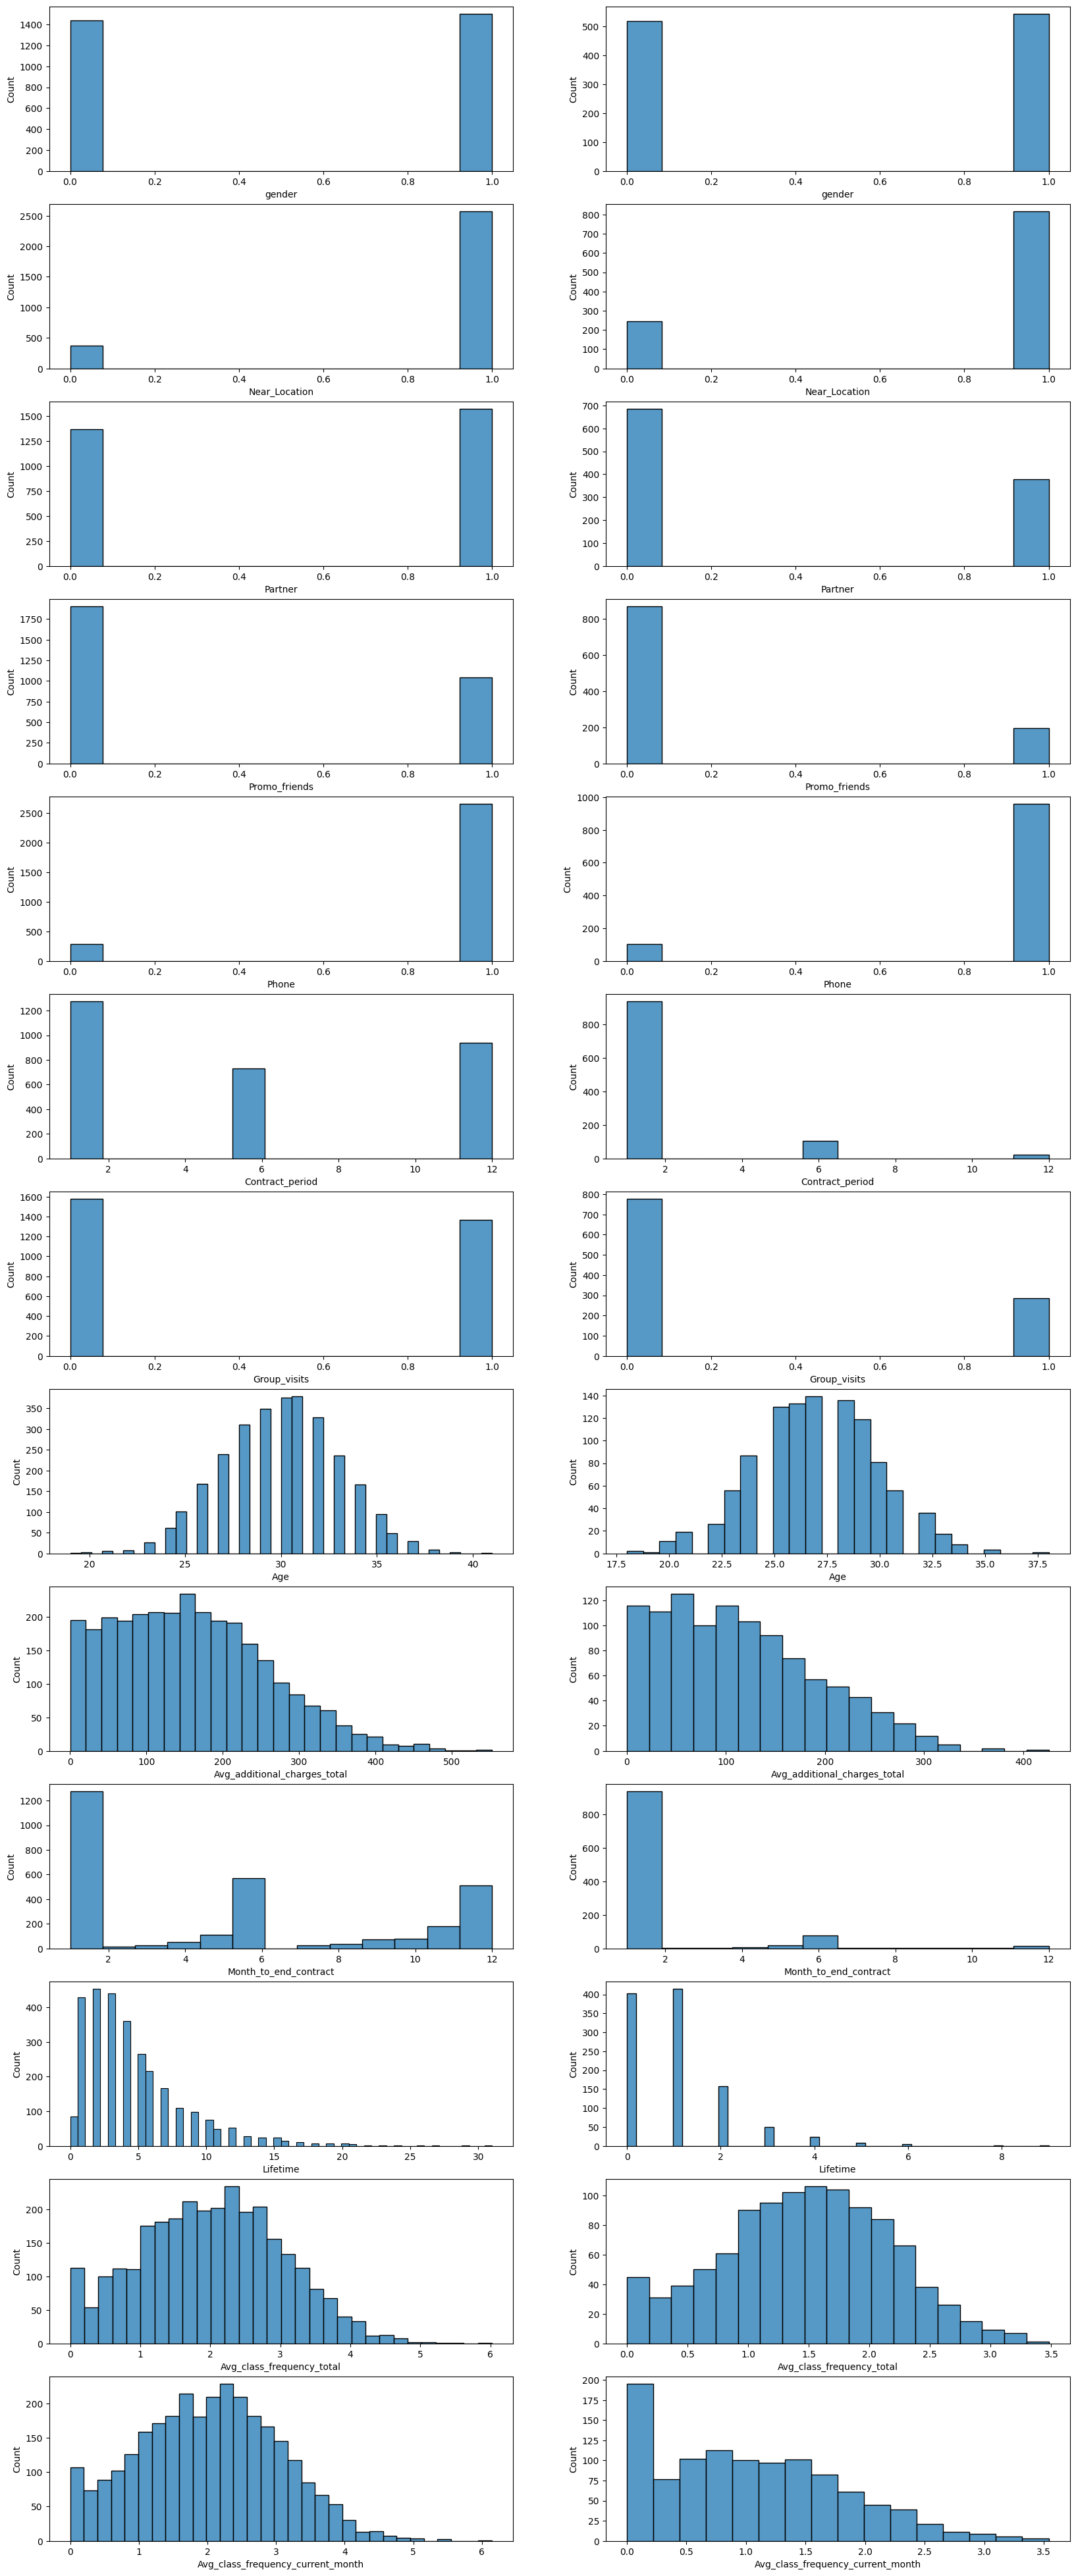

In [11]:
# Построим диагруммы распределения признаков
# Создаем подграфики
fig, axs = plt.subplots(len(gym_churn_stayed.drop('Churn', axis = 1).columns), 2, figsize=(20, 50))

# Создаем гистограммы для тех кто остался
for i, col in enumerate(gym_churn_stayed.drop('Churn', axis = 1).columns):
  sns.histplot(gym_churn_stayed[col], ax=axs[i, 0])

# Создаем гистограммы для тех кто ушел
for i, col in enumerate(gym_churn_gone.drop('Churn', axis = 1).columns):
  sns.histplot(gym_churn_gone[col], ax=axs[i, 1])

plt.show()

После построение диаграмм распределения признаков по двум группам. Видим что Возрастные группы имеют небольшие отличия. В группе ушедших возраст находится в диапазоне от 18 до 38, а тех кто остался до 41 года. Так же есть различия в суммарной выручке от услуг. Для тех кто ушел диапазон от 0 до 400, а вот тех кто остался до 500 и более. Заметны значительные различия в длительности посещения. Для тех кто ушел диапазон от 0 до 9 месяцев, а для тех кто остался от 0 до 31 месяца. Аналогично различается средняя частота посещений для ушедших от 0 до 3,5 месяцев и от 0 до 6 месяцев для оставшихся.

То есть те кто остается пользуются услугами фитнес-центра дольше и в большем объеме. А вот недавно пришедшие новички склонны к оттоку больше.

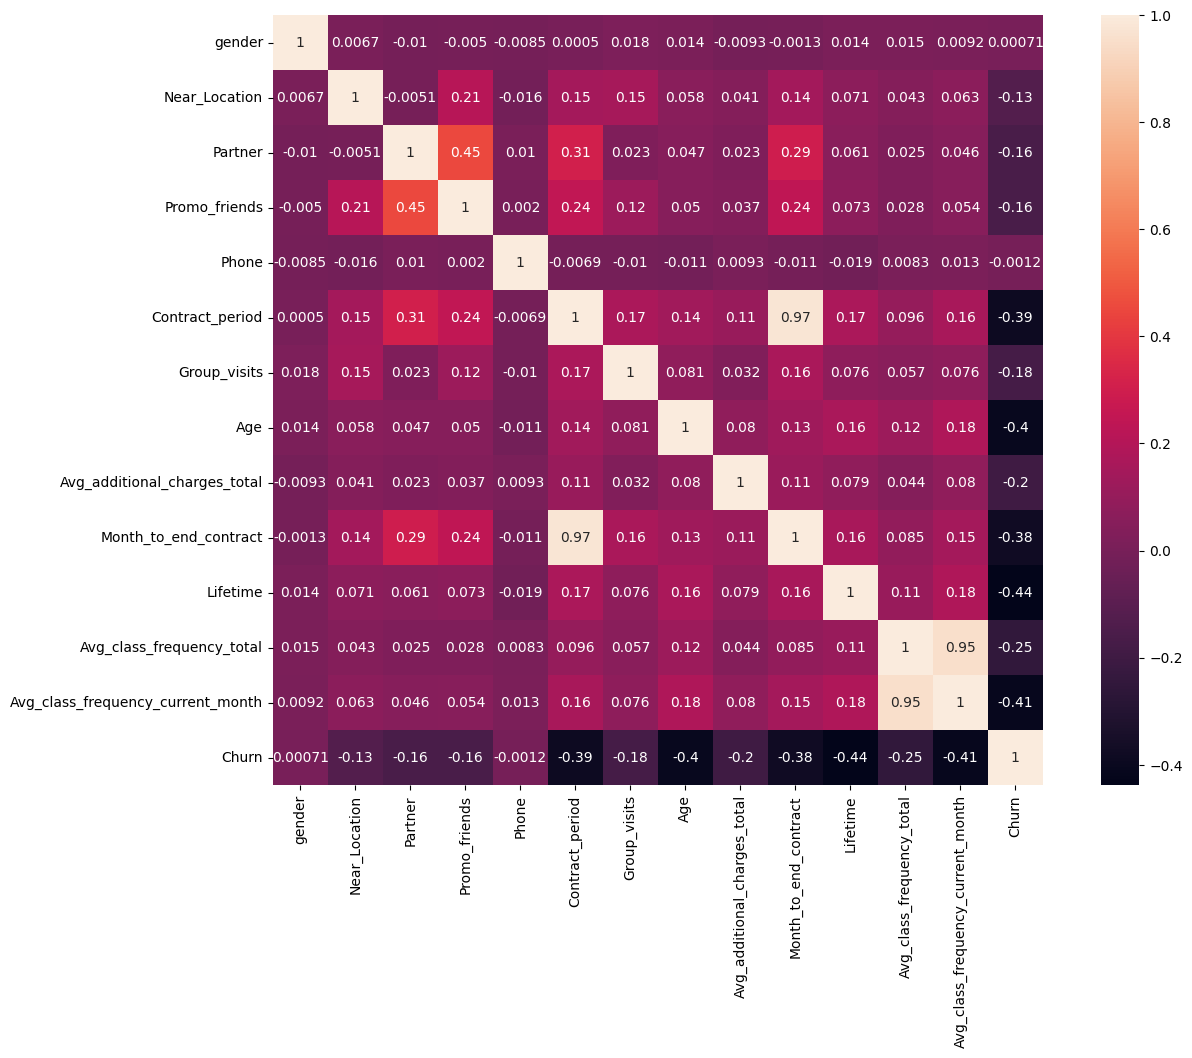

In [12]:
# Построим матрицу корреляций
cm = gym_churn.corr()
fig, ax = plt.subplots(figsize=(15, 10))

# Нарисуем тепловую карту с подписями для матрицы корреляций
sns.heatmap(cm, annot=True, square=True)  #ваш код здесь
ax.set_ylim(14, 0)

plt.show()

По данным матрицы видим что есть обратная зависимость с некоторыми показателями. Это приод контакта, возраст, месяцев до завершения контракта, длительность посещения и сммарная выручка от других услуг фитнес-центра. При этом стоит отметить что зависимость не ярко выражена.

**Выводы:**

Пустых строк в таблице нет.

В группе оттока находится меньше пользователей кто проживает или работает в районе фитнес-центра. Так же меньше сотрудников компаний партнеров и тех кто пришел по акции "Приведи друга". При этом больше пользователей у кого длительность текущего абонемента от 1 до 2 месяцев и время до заверения контракта в этом же интервале. Меньше пользователей кто посещал групповые занятия. В группе оттока меньше суммарная выручка от других услуг фитнес-центра. Так же в группе оттока в несколько раз меньше время с момента первого визита.

То есть те кто остается пользуются услугами фитнес-центра дольше и в большем объеме. А вот недавно пришедшие новички склонны к оттоку больше.

Есть обратная зависимость с некоторыми показателями. Это приод контакта, возраст, месяцев до завершения контракта, длительность посещения и суммарная выручка от других услуг фитнес-центра. При этом стоит отметить что зависимость не ярко выражена.

#### Шаг 3. Построение модели прогнозирования оттока пользователей

In [13]:
# Разделим данные на признаки (матрица X) и целевую переменную (y)
X = gym_churn.drop(columns=['Churn'])
y = gym_churn['Churn']

In [14]:
# Hазделим модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Зададим список моделей
models = [
    LogisticRegression(max_iter=1000, random_state=42),
    RandomForestClassifier(random_state=42),
    GradientBoostingClassifier(random_state=42)
]

В списке моделей добавил еще градиентный бустиг. По причине того что на встрече с наставником узнал что лучший результат можно получить именно при помощи бустинга. Для проверки его и добавил.

In [16]:
# Добавим функцию, которая принимает на вход модель и данные и выводит метрики
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(
        'Accuracy:{:.2f} Precision:{:.2f} Recall:{:.2f} '.format(
            accuracy_score(y_test, y_pred),
            precision_score(y_test, y_pred),
            recall_score(y_test, y_pred)
        )
    )

In [17]:
for i in models:
    print(i)
    make_prediction(i, X_train, y_train, X_test, y_test)

LogisticRegression(max_iter=1000, random_state=42)
Accuracy:0.92 Precision:0.87 Recall:0.78 
RandomForestClassifier(random_state=42)
Accuracy:0.91 Precision:0.85 Recall:0.78 
GradientBoostingClassifier(random_state=42)
Accuracy:0.92 Precision:0.89 Recall:0.80 


**Вывод:**

По доле правильных ответов(Accuracy) лучше всего справились две модели:
- Логистическая регрессия;
- Градиентный бустинг.
Обе модели показали результат в 92%. При этом доверять только показателю точности нельзя. Так как наши данные распределены не равномерно по группам. В группе оттока пользователей меньше.

А вот метрики точности и полноты(Precision и Recall) лучше всего у градиентного бустинга и составили 89 и 80% соответственно.
Из всех метрик делаем вывод что лучше всего справилась модель градиентного бустинга(GradientBoostingClassifier). Поэтому для дальнейго прогнозирования оттока лучше использовать именно ее.


#### Шаг 4. Кластеризация пользователей

In [18]:
# Стандартизируем данные
sc = StandardScaler()
X_sc = sc.fit_transform(gym_churn)
# Построим матрицу расстояний
linked = linkage(X_sc, method = 'ward')

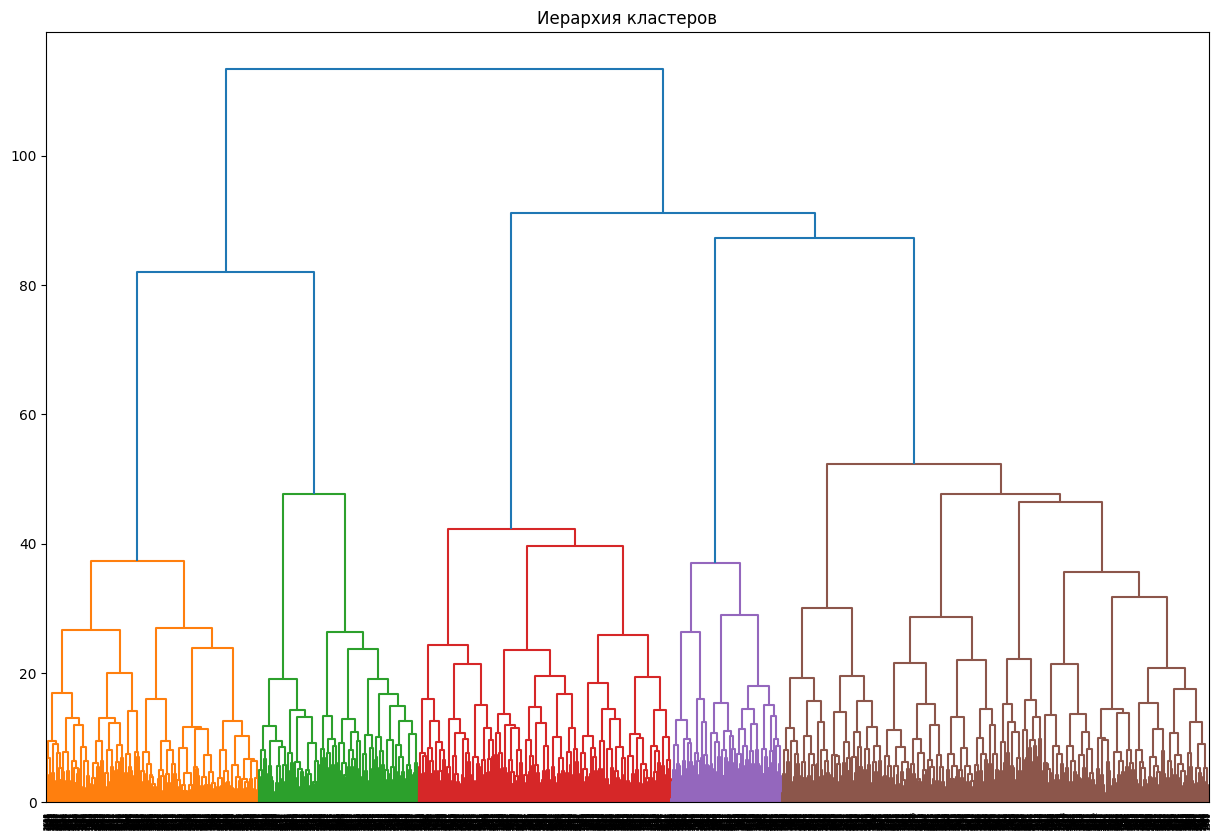

In [19]:
# Отобразим дендрограмму
plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top')
plt.title('Иерархия кластеров')
plt.show()

На основании дендрограммы видим что можно сформировать 5 больших групп(кластеров).

In [20]:
# Проведем кластеризацию с импользованием KMeans и разбивкой на 5 кластеров
km = KMeans(n_clusters=5, random_state=42)

labels = km.fit_predict(X_sc)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [21]:
# Сохраняем метки кластера в датасете
gym_churn['cluster_km'] = labels

# Выведем статистику по средним значениям наших признаков по кластеру
display(gym_churn.groupby(['cluster_km']).mean())

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
cluster_km,,,,,,,,,,,,,,
0,0.475638,0.827146,0.447796,0.254060,1.000000,2.647332,0.381671,30.010441,153.532535,2.464037,4.674014,1.180614,1.179787,0.001160
1,0.503106,0.938923,0.768116,0.564182,1.000000,11.173913,0.557971,29.899586,161.514913,10.223602,4.704969,2.006679,2.001081,0.015528
2,0.550059,0.840989,0.374558,0.215548,0.998822,2.750294,0.441696,29.984688,160.178822,2.528857,4.588928,2.930098,2.936773,0.007067
3,0.524804,0.866841,0.469974,0.308094,0.000000,4.806789,0.428198,29.331593,144.156967,4.493473,3.945170,1.855107,1.723740,0.263708
4,0.507447,0.760638,0.341489,0.179787,0.997872,1.567021,0.257447,26.908511,115.109065,1.513830,0.976596,1.448700,1.026250,0.997872


**Вывод:**

На основании средних значений по кластерам можно предположить что к **1** кластеру относятся пользователи которые являются сотрудниками компаний партнеров фитнес-ценрта. У них долше всех длителность контрактов и длительность посещения. Так же в этом кластере больше всего пользователей по акции приведи друга.

Кластер **нулевой** по всей видимости постоянные пользователи не склонные к оттоку и продолжительной длительностью посещения фитнес-центра.

Кластер **2** очень похож на нулевой единственное отличие это большая частота посещений.

А вот в **3** кластере находятся пользователи с меньшей длительностью посещения и большей вероятностью оттока. При это в данном кластере у пользователей не указан контактный номер телефона.

И в последнем **4** находятся новички кто недавно пришел в фитнес-центр. У них как раз самая большая вероятность оттока и наиментший средний возраст.


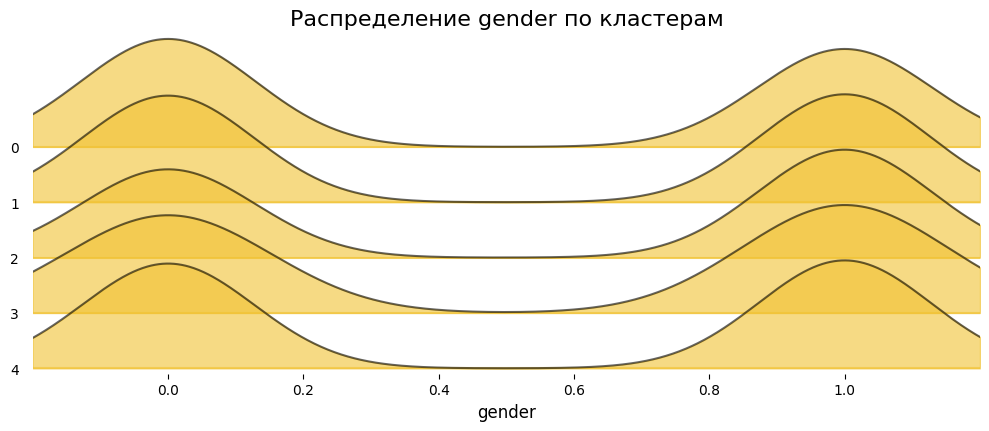

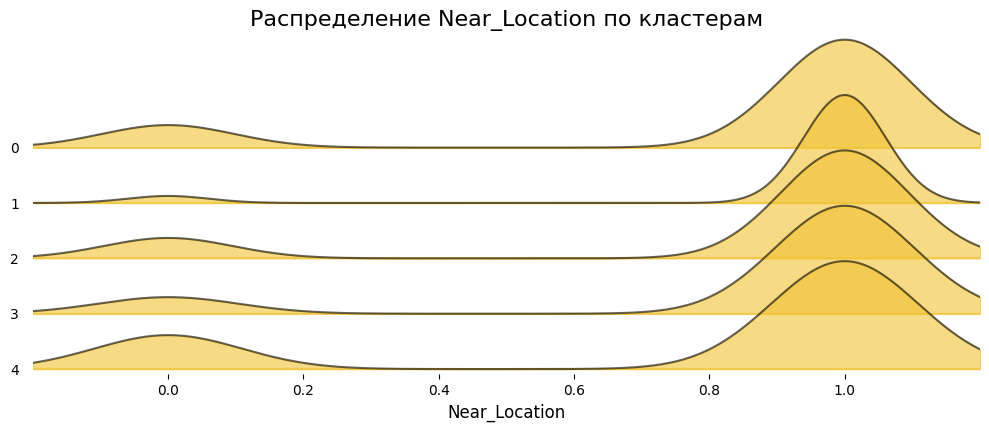

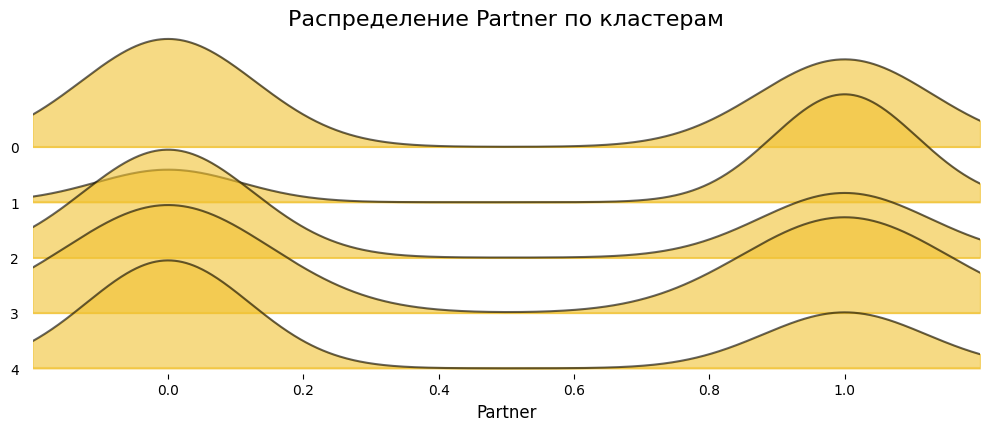

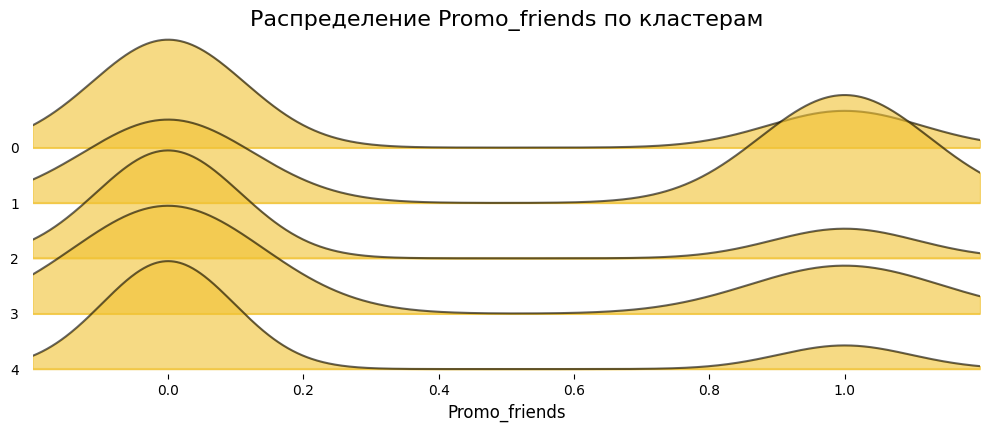

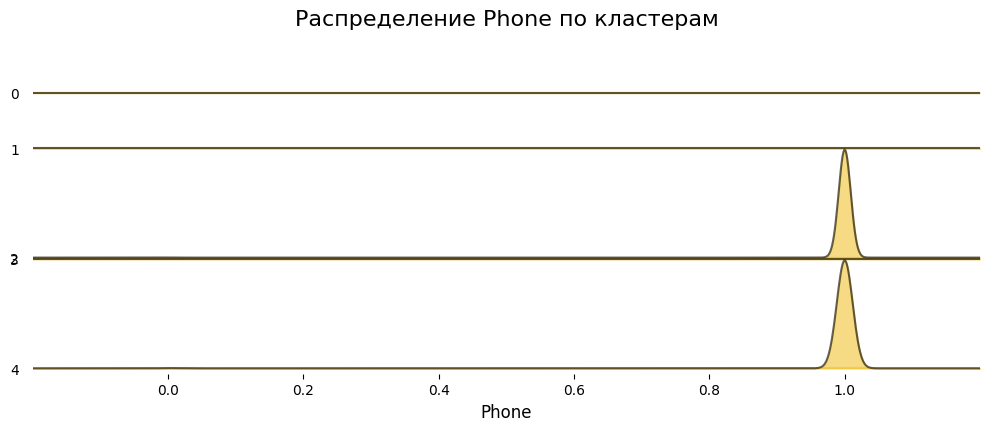

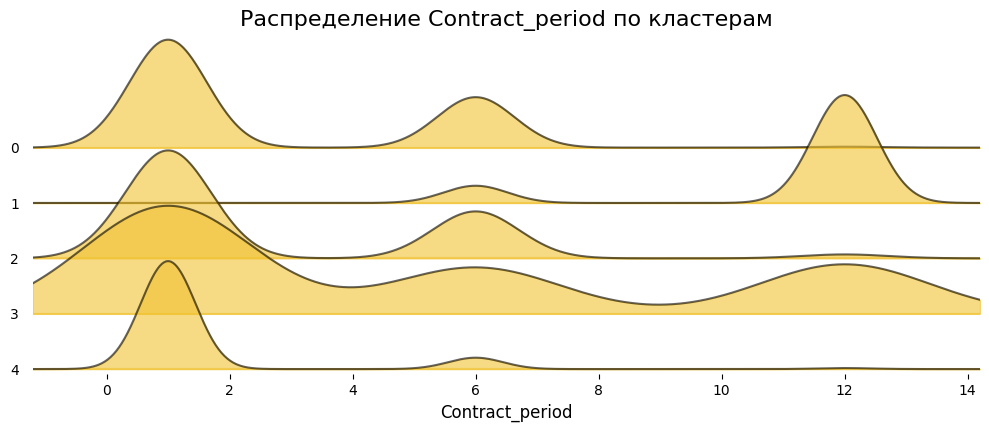

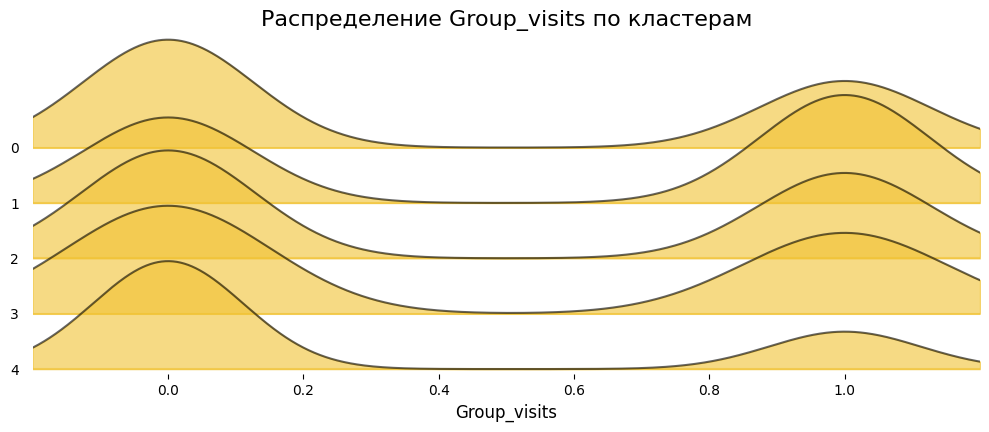

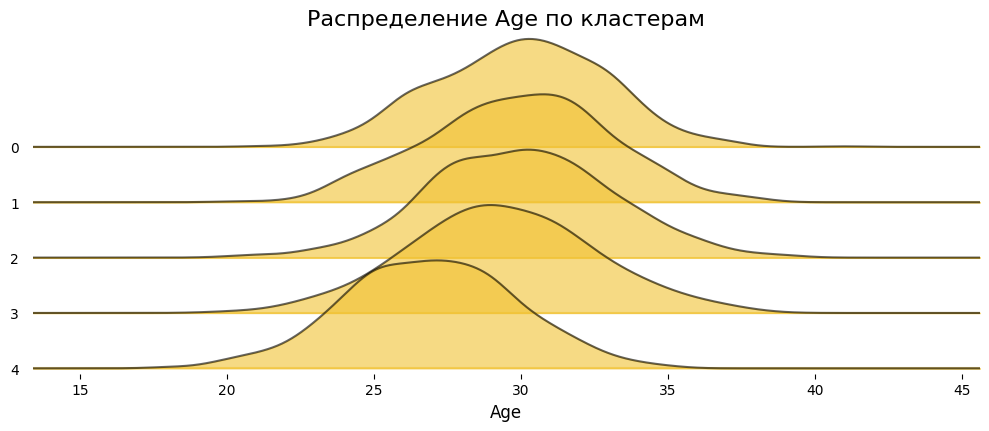

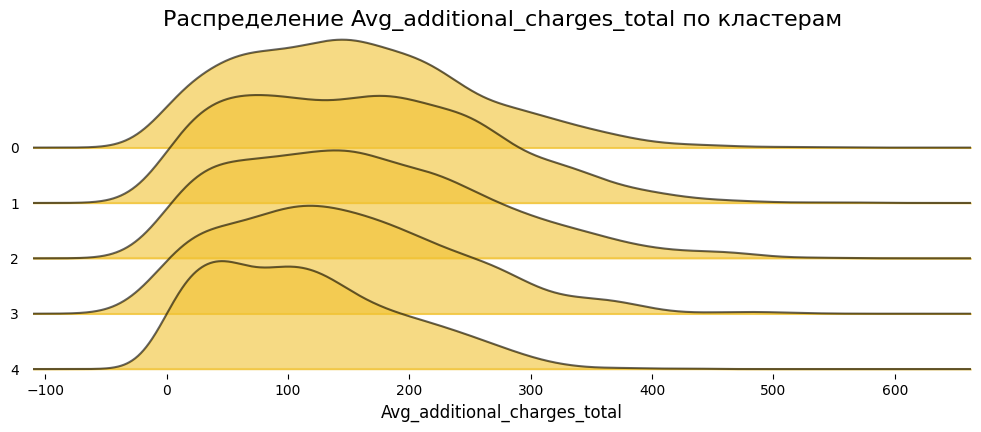

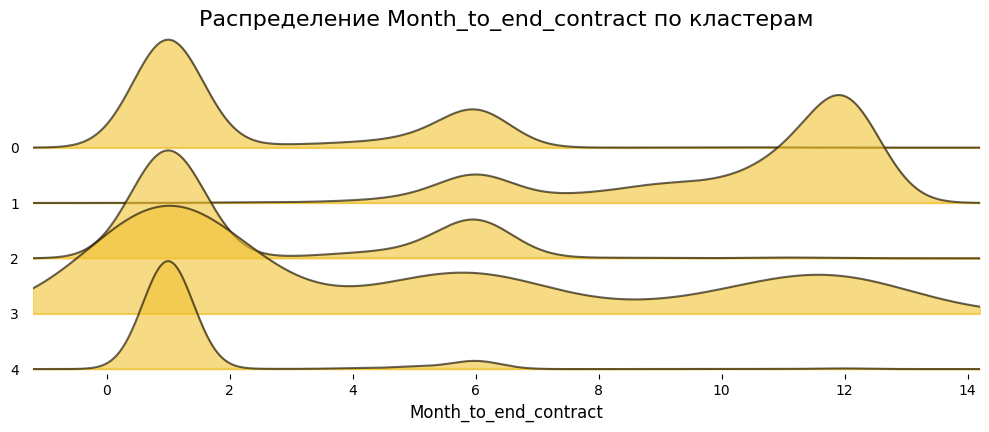

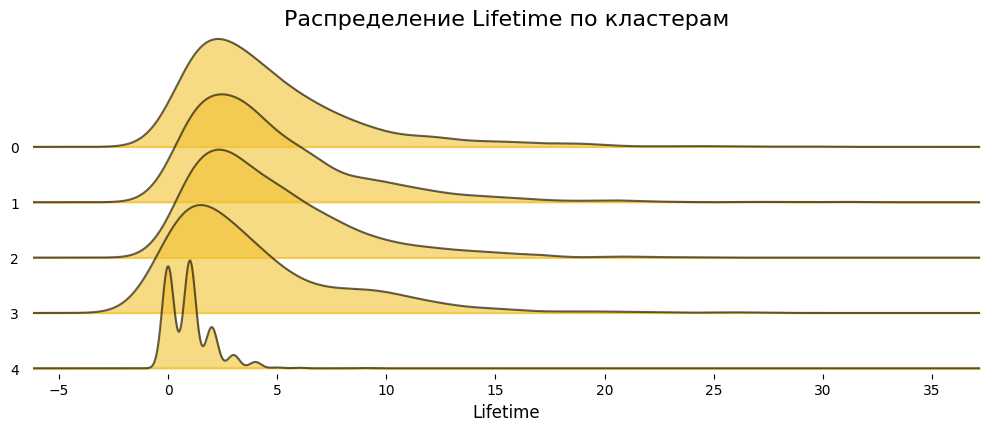

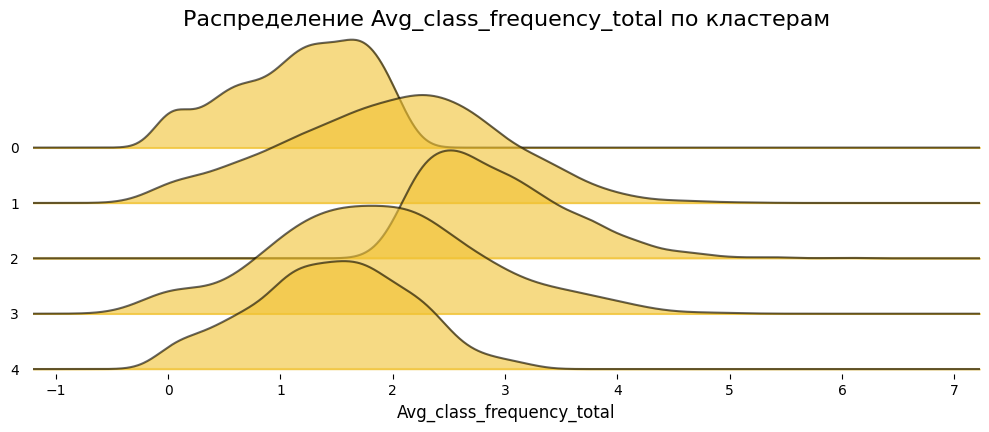

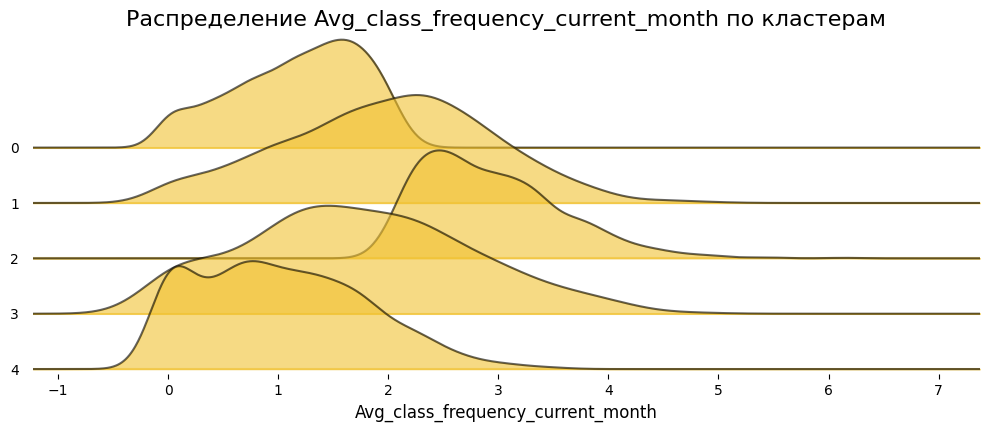

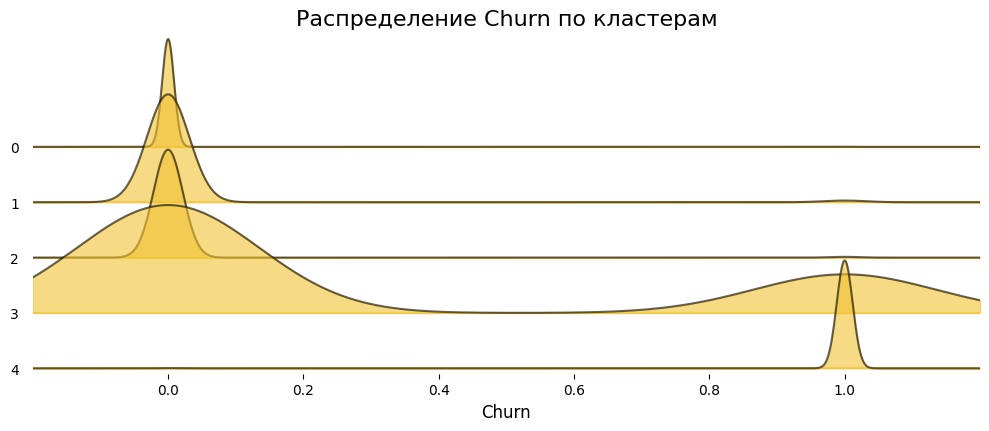

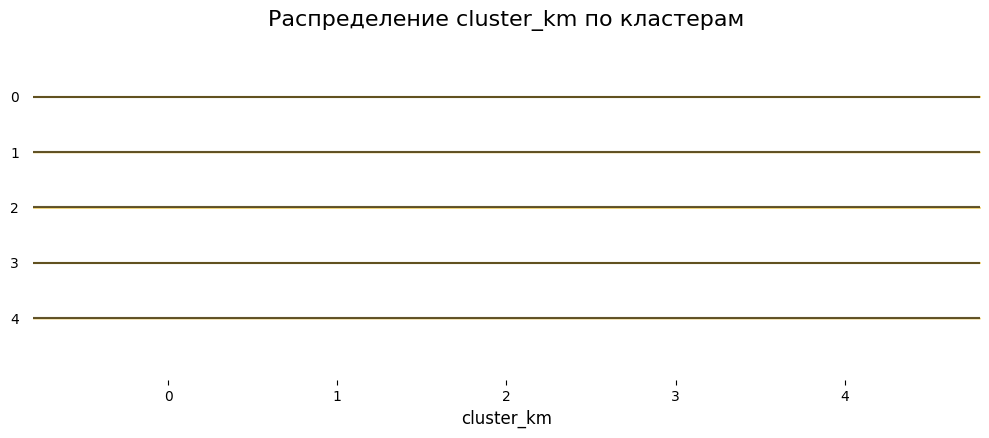

In [22]:
# Отрисуем графики распределений
for column in gym_churn.columns:
   fig, axes = joypy.joyplot(gym_churn, column=[column], by="cluster_km", ylim='own',
                            figsize=(10,4), color='#f1c232', alpha=0.6)
   plt.title(f'Распределение {column} по кластерам', fontsize=16)
   plt.xlabel(column, fontsize=12)
   plt.show()

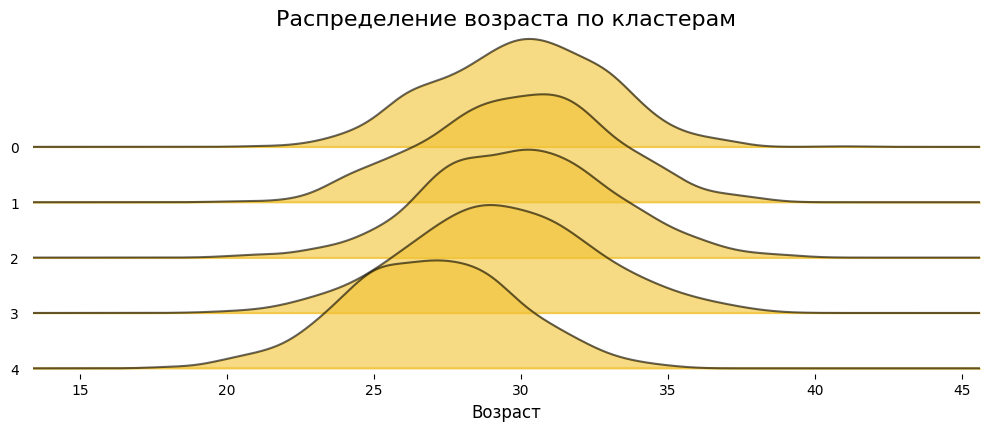

In [23]:
fig, axes = joypy.joyplot(gym_churn, column=['Age'], by="cluster_km", ylim='own',
                          figsize=(10,4), color='#f1c232', alpha=0.6)
plt.title('Распределение возраста по кластерам', fontsize=16)
plt.xlabel('Возраст',  fontsize=12)
plt.show()

###### По графикам видим, что в 4 кластере действительно находятся новички, при этом у кластера самый меньший средний возраст. Так же заметно что данный кастер меньше посещает групповые занятия. Подтверждается наибольшая вероятность оттока пользователей данного кластера.
Заметно, что для кластеров 4, 2 и 0 срок действия контракта наименьший и составляет в районе 2 месяцев.


In [24]:
# Вычислим количество пользователей в каждом кластере
user_counts = gym_churn['cluster_km'].value_counts()

# Вычислим количество пользователей, которые ушли в каждом кластере
churn_counts = gym_churn[gym_churn['Churn'] == 1]['cluster_km'].value_counts()

# Вычислим долю оттока для каждого кластера
churn_rates = round((churn_counts / user_counts) * 100,2)

In [25]:
churn_rates

0     0.12
1     1.55
2     0.71
3    26.37
4    99.79
Name: cluster_km, dtype: float64

Видим что в первых трех кластерах отток не превышает 2%, а вот в 3 он уже составляет 26,37%. При этом в 4 кластере практически 100%

**Вывод:**

На основании средних значений по кластерам можно предположить что к 1 кластеру относятся пользователи которые являются сотрудниками компаний партнеров фитнес-ценрта. У них дольше всех длителность контрактов и длительность посещения. Так же в этом кластере больше всего пользователей по акции приведи друга.

Кластер нулевой по всей видимости постоянные пользователи не склонные к оттоку и продолжительной длительностью посещения фитнес-центра.

Кластер 2 очень похож на нулевой единственное отличие это большая частота посещений.

А вот в 3 кластере находятся пользователи с меньшей длительностью посещения и большей вероятностью оттока. При это в данном кластере у пользователей не указан контактный номер телефона.

И в последнем 4 находятся новички кто недавно пришел в фитнес-центр. У них как раз самая большая вероятность оттока и наименьший средний возраст.

По графикам видим, что в 4 кластере действительно находятся новички, при этом у кластера самый меньший средний возраст. Так же заметно что данный кастер меньше посещает групповые занятия. Подтверждается наибольшая вероятность оттока пользователей данного кластера. Заметно, что для кластеров 4, 2 и 0 срок действия контракта наименьший и составляет в районе 2 месяцев.

Сравнение кластеров по доле оттока подтверждает, что 4 кластер явлется основным по оттоку, доля оттока в нем практически 100%. При этом в первых трех кластерах отток не превышает 2%, а вот в 3 он уже составляет 26,37%.

#### Шаг 5. Выводы и базовые рекомендации

В группе оттока находится меньше пользователей кто проживает или работает в районе фитнес-центра. Так же меньше сотрудников компаний партнеров и тех кто пришел по акции "Приведи друга". При этом больше пользователей у кого длительность текущего абонемента от 1 до 2 месяцев и время до заверения контракта в этом же интервале. Меньше пользователей кто посещал групповые занятия. В группе оттока меньше суммарная выручка от других услуг фитнес-центра. Так же в группе оттока в несколько раз меньше время с момента первого визита.

То есть те кто остается пользуются услугами фитнес-центра дольше и в большем объеме. А вот недавно пришедшие новички склонны к оттоку больше.

Есть обратная зависимость с некоторыми показателями. Это приод контакта, возраст, месяцев до завершения контракта, длительность посещения и суммарная выручка от других услуг фитнес-центра. При этом стоит отметить что зависимость не ярко выражена.

По доле правильных ответов(Accuracy) лучше всего справились две модели:

Логистическая регрессия;
Градиентный бустинг.

Обе модели показали результат в 92%. При этом доверять только показателю точности нельзя. Так как наши данные распределены не равномерно по группам. В группе оттока пользователей меньше.
А вот метрики точности и полноты(Precision и Recall) лучше всего у градиентного бустинга и составили 89 и 80% соответственно. Из всех метрик делаем вывод что лучше всего справилась модель градиентного бустинга(GradientBoostingClassifier). Поэтому для дальнейго прогнозирования оттока лучше использовать именно ее.


*В результате кластеризации получили:*

**Кластер 1:** Пользователи этого кластера, скорее всего, являются сотрудниками компаний-партнеров фитнес-центра. У них наибольшая длительность контрактов и посещений. Кроме того, в этом кластере больше всего пользователей по акции "приведи друга".

**Кластер 0:** Этот кластер, вероятно, включает в себя постоянных пользователей, которые не склонны к оттоку и имеют продолжительную длительность посещения фитнес-центра.

**Кластер 2:** Этот кластер очень похож на кластер 0, единственное отличие - большая частота посещений.

**Кластер 3:** В этом кластере находятся пользователи с меньшей длительностью посещения и большей вероятностью оттока. Также в этом кластере у пользователей не указан контактный номер телефона.

**Кластер 4:** Этот кластер, вероятно, включает в себя новичков, которые недавно пришли в фитнес-центр. У них самая большая вероятность оттока и наименьший средний возраст. Кроме того, кластер 4 меньше посещает групповые занятия.

Так же стоит отметить что для кластеров 4, 2 и 0 срок действия контракта наименьший и составляет в районе 2 месяцев.

Сравнение кластеров по доле оттока подтверждает, что кластер 4 является основным по оттоку, доля оттока в нем практически 100%. В первых трех кластерах отток не превышает 2%, а в кластере 3 он уже составляет 26,37%.

Таким образом, можно сделать вывод, что для удержания пользователей в фитнес-центре необходимо усилить маркетинговые и рекламные кампании, направленные на кластер 4, а также рассмотреть возможность предложения специальных условий или скидок для пользователей кластера 3.

*Рекомендации для фитнес-центра:*
    
- **Усиление маркетинговых и рекламных кампаний для кластера 4:** Это может включать в себя рекламные акции, специальные предложения или скидки, а также регулярные обновления и улучшения услуг. Специальные условия, скидки, специальные программы лояльности или специальные услуги так же подойдут и для кластера 3.

- **Программы поощрения:** Такие как бонусы за посещение определенного количества занятий, награды за достижение определенных результатов или специальные скидки для постоянных посетителей.

- **Персонализация обслуживания клиентов:** Например персонализированные программы тренировок, советы по питанию или советы по здоровому образу жизни.

- **Сбор обратной связи от клиентов:** Это могут быть анкеты, опросы или обратная связь через социальные сети.

- **Улучшение качества услуг:** Например улучшение инфраструктуры фитнес-центра, обучение персонала или улучшение программ тренировок.